### Prerequisites

In [11]:
# Import necessary packages
import torch
import torch.nn as nn
from torch.optim import Adam, LBFGS
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import numpy as np
import pygmsh as pgm
import matplotlib
import matplotlib.pyplot as plt
import time

# Select the running mode: True-training, False-prediction
runMode = True

# Choose the material
material = 'Mn2S2'

# Settle the calculation of my model onto GPU
torch.cuda.init()
if torch.cuda.is_available():
    torch.set_default_device("cuda")
    print("CUDA is being used")

CUDA is being used


### Parameters in the governing equations and normalization

Material constants are defined here, as well as the radius of the bubble and uniform pressure. To avoid possible ill-conditioned training caused by extreme values, the radius and pressure are normalized as
$$A=\frac{a}{h_\text{e}},\quad Q = \frac{2qh_\text{e}^3}{D_{11} + D_{22}}$$
where $h_e$ is a pseudo-thickness expected to be specified by users to scale up geometric quantities. $h_\text{e}=0.1\text{nm}$ is set for reference.

The examples presented cover four types of symmetries of 2D crystals, including
- Graphene(hexagonal) referred in https://doi.org/10.1115/1.4024169 and https://pubs.acs.org/doi/10.1021/nl303168w
- $\text{Mn}_2\text{S}_2$ (square) referred in https://c2db.fysik.dtu.dk/material/2MnS-2
- Black phosphorene (BP, rectangular) referred in https://doi.org/10.1063/1.4885215 and https://doi.org/10.1016/j.ijmecsci.2024.109501
- $\text{PdCdCl}_4$ (oblique) referred in https://c2db.fysik.dtu.dk/material/1CdPdCl4-1

The material non-linearity of graphene can be referred in http://dx.doi.org/10.1103/PhysRevB.80.205407.

It is noted that the bending rigidities for the second and forth crystals are assigned referring to the magnitude of the ones of the other crystals and are not rigorously and computationally determined.


In [12]:
a = 10e-9   # radius
q = 307.4e6 # transverse loading

a = 2*a
q = q
'''
Examples of general 2D crystalline structures[SI units]
-----------------------------------------
Hexagonal: Graphene
# In-plane stiffness matrix
C11_2D = 354.1
C22_2D = 354.1
C12_2D = 56.7
C16_2D = 0
C26_2D = 0
C66_2D = 148.7
# Out-of-plane stiffness matrix
D11 = 2.38e-19
D22 = 2.38e-19
D12 = -0.05e-19
D16 = 0
D26 = 0
D66 = 1.215e-19
-----------------------------------------
Square: Mn2S2
# In-plane stiffness matrix
C11_2D = 121.83
C22_2D = 121.83
C12_2D = 33.90
C16_2D = 0
C26_2D = 0
C66_2D = 108.45
# Out-of-plane stiffness matrix
D11 = 1.0e-18
D22 = 1.0e-18
D12 = 0.25e-18
D16 = 0.0
D26 = 0.0
D66 = 1.0e-18
-----------------------------------------
Rectangular: BP
# In-plane stiffness matrix
C11_2D = 102.98
C22_2D = 27.30
C12_2D = 17.51
C16_2D = 0
C26_2D = 0
C66_2D = 22.76
# Out-of-plane stiffness matrix
D11 = 1.421e-18
D22 = 0.307e-18
D12 = 0.336e-18
D16 = 0
D26 = 0
D66 = 0.175e-18
-----------------------------------------
Oblique: PdCdCl4
# In-plane stiffness matrix
C11_2D = 12.38
C22_2D = 37.00
C12_2D = 8.50
C16_2D = 3.24
C26_2D = 9.76
C66_2D = 14.48
# Out-of-plane stiffness matrix
D11 = 1.0e-18
D22 = 3.0e-18
D12 = 0.6e-18
D16 = 0.25e-18
D26 = 0.75e-18
D66 = 1.0e-18
'''

# Pseudo-thickness
he = 0.1e-9

# In-plane stiffness matrix
C11_2D = 121.83
C22_2D = 121.83
C12_2D = 33.90
C16_2D = 0
C26_2D = 0
C66_2D = 108.45
# Out-of-plane stiffness matrix
D11 = 1.0e-18
D22 = 1.0e-18
D12 = 0.25e-18
D16 = 0.0
D26 = 0.0
D66 = 1.0e-18

# Normalization
Q = 2*q*he**3/(D11 + D22)
A = a/he

# Scale up bending stiffness
B11 = D11/he**2
B22 = D22/he**2
B12 = D12/he**2
B16 = D16/he**2
B26 = D26/he**2
B66 = D66/he**2

### Define the neural network

We have three outputs, $U$, $V$ and $W$ in total, and we assign each of them with an individual network to improve the efficiency and accuracy.

These outputs don't correspond to the real displacement of the bubble, but the normalized ones
$$U=\frac{u}{h_\text{e}}, V = \frac{v}{h_\text{e}}, W = \frac{w}{h_\text{e}}$$
Similarly, the inputs $X$, $Y$ relates to the real coordinates through
$$X = \frac{x}{h_\text{e}}, Y = \frac{y}{h_\text{e}}$$



In [13]:
class Net(nn.Module):
    # Define a new class inheriting nn.Module
    def __init__(self, nInput, nOutput, hiddenSizes):
        # Initialize basic information for the network
        super(Net, self).__init__()

        # Define the input layer: reflection + weight + bias
        self.Input = nn.Linear(nInput, hiddenSizes[0])
        nn.init.xavier_uniform_(self.Input.weight)
        nn.init.normal_(self.Input.bias)

        # Define the output layer: reflection + weight + bias
        self.Output = nn.Linear(hiddenSizes[-1], nOutput)
        nn.init.xavier_uniform_(self.Output.weight)
        nn.init.normal_(self.Output.bias)

        # Define the hidden layers: reflection + weight + bias
        self.Hidden = nn.ModuleList()
        for i in range(len(hiddenSizes) - 1):
            layer = nn.Linear(hiddenSizes[i], hiddenSizes[i+1])
            nn.init.xavier_uniform_(layer.weight)
            nn.init.normal_(layer.bias)
            self.Hidden.append(layer)

    # Define the activation function
    def forward(self, inputData):
        tensor = torch.tanh(self.Input(inputData))
        for layer in self.Hidden:
            tensor = torch.tanh(layer(tensor))
        outputData = self.Output(tensor)
        return outputData

### Define derivatives

In [14]:
def Derivatives(inputData, Net, func_HBC):
    outputData = Net(inputData)*(func_HBC(inputData).view(-1, 1))
    # Evaluate first derivatives
    jacobian = torch.autograd.grad(outputData,
                                   inputData,
                                   torch.ones_like(outputData),
                                   retain_graph = True,
                                   create_graph = True,
                                   allow_unused = True)
    partial_X = jacobian[0][:, 0].view(-1, 1)
    partial_Y = jacobian[0][:, 1].view(-1, 1)

    # Evaluate second derivatives
    hessianX = torch.autograd.grad(partial_X,
                                   inputData,
                                   torch.ones_like(partial_X),
                                   retain_graph = True,
                                   create_graph = True,
                                   allow_unused = True)
    hessianY = torch.autograd.grad(partial_Y,
                                   inputData,
                                   torch.ones_like(partial_Y),
                                   retain_graph = True,
                                   create_graph = True,
                                   allow_unused = True)
    partial_XX = hessianX[0][:, 0].view(-1, 1)
    partial_YY = hessianY[0][:, 1].view(-1, 1)
    partial_XY = 0.5*(hessianX[0][:, 1].view(-1, 1) + hessianY[0][:, 0].view(-1, 1))

    return partial_X, partial_Y, partial_XX, partial_YY, partial_XY

### Evaluate the free energy
This is the cell where users can define constitutive laws.

Defining the normalized curvatures
$$K_{ij} = -\partial_{X_iX_j}W$$
The internal moments can be determined in terms of curvatures once the constitutive relation is known. Likewise, the normalized strain can be defined as
$$E_{ij} = \frac{1}{2}(\partial_{X_i}U_j + \partial_{X_j}U_i + \partial_{X_i}W\partial_{X_j}W)=\varepsilon_{ij}$$
The membrane forces can be determined in terms of strains once the constitutive relation is known.

In [15]:
def freeEnergy(inputData, NetU, NetV, NetW, funcUV, funcW):
    # Deflection
    W = NetW(inputData)*(funcW(inputData).view(-1, 1))

    # Evaluate derivatives
    U_X, U_Y, _, _, _ = Derivatives(inputData, NetU, funcUV)
    V_X, V_Y, _, _, _ = Derivatives(inputData, NetV, funcUV)
    W_X, W_Y, W_XX, W_YY, W_XY = Derivatives(inputData, NetW, funcW)

    # Evaluate strains and curvatures
    EX = U_X + 0.5*W_X**2
    EY = V_Y + 0.5*W_Y**2
    GXY = U_Y + V_X + W_X*W_Y
    KX, KY, KXY = -W_XX, -W_YY, -W_XY

    # Constitutive equations
    NX = C11_2D*EX + C12_2D*EY + C16_2D*GXY
    NY = C12_2D*EX + C22_2D*EY + C26_2D*GXY
    NXY = C16_2D*EX + C26_2D*EY + C66_2D*GXY

    MX = B11*KX + B12*KY + B16*KXY
    MY = B12*KX + B22*KY + B26*KXY
    MXY = B16*KX + B26*KY + B66*2*KXY

    # Evaluate potential energy density
    U_m = 0.5*(NX*EX + NY*EY + NXY*GXY)

    '''
    The material non-linearity for graphene
    U_m_nl = (1/6*(C111_2D*EX**3 + C222_2D*EY**3) + C112_2D*EX**2*EY +
              (C111_2D - C222_2D + C112_2D)*EX*EY**2 + (3/4*C222_2D - 1/2*C111_2D - 1/4*C112_2D)*EX*GXY**2 +
              (1/2*C111_2D - 1/4*C222_2D - 1/4*C112_2D)*EY*GXY**2)
    U_m = U_m + U_m_nl
    '''
    U_b = 0.5*(MX*KX + MY*KY + MXY*(2*KXY))


    # Evaluate the total energy over the domain
    Phi_m, Phi_b = torch.mean(U_m), torch.mean(U_b)

    V = torch.mean(-0.5*Q*(B11 + B22)*W)
    return Phi_m, Phi_b, V

### Define the training data

To ensure training points are uniformly distributed over the domain,
$$R=A\sqrt{U_1},\theta=2\pi U_2$$
where $U_1 \sim  \text{Uniform}(0,1)$ and $U_2 \sim \text{Uniform}(0, 1)$ are independent.

In [16]:
def trainingData(nSample):
    R = A*torch.sqrt(torch.rand(nSample))
    Theta = 2*torch.pi*torch.rand(nSample)
    X, Y = R*torch.cos(Theta), R*torch.sin(Theta)
    coordinates = (torch.stack((X, Y), dim=1).requires_grad_(True))

    return coordinates

 ### Preparation before training
Auxiliary functions $(1-R^2/A^2)$ and $(1-R^2/A^2)^2$ are used to guarantee the clamped boundary

In [17]:
# Set up training data
nSample = 100000

inputData = trainingData(nSample)

# Construct neural networks for each output
hiddenSizesW = [32, 64, 64, 64, 32]
hiddenSizesUV = [32, 64, 64, 64, 32]

NetU = Net(2, 1, hiddenSizesUV)
NetV = Net(2, 1, hiddenSizesUV)
NetW = Net(2, 1, hiddenSizesW)

# Impose hard boundary conditions
def funcUV(inputData):
    R_square = inputData[:, 0]**2 + inputData[:, 1]**2

    return (1 - R_square/A**2)

def funcW(inputData):
    R_square = inputData[:, 0]**2 + inputData[:, 1]**2

    return (1 - R_square/A**2)**2

### Training
Two stages of optimization and scheduler for learning rate are adopted.

Epoch:100, Total:-1.3928e-01, Membrane:8.7649e-04, Bending:1.6224e-04, External:-1.4032e-01 
Epoch:200, Total:-2.0272e-01, Membrane:4.0407e-03, Bending:3.5933e-04, External:-2.0712e-01 
Epoch:300, Total:-2.6162e-01, Membrane:9.6522e-03, Bending:6.1666e-04, External:-2.7189e-01 
Epoch:400, Total:-3.1195e-01, Membrane:1.9672e-02, Bending:9.2525e-04, External:-3.3255e-01 
Epoch:500, Total:-3.5006e-01, Membrane:3.6639e-02, Bending:1.2528e-03, External:-3.8795e-01 
Epoch:600, Total:-3.7716e-01, Membrane:5.6709e-02, Bending:1.5656e-03, External:-4.3543e-01 
Epoch:700, Total:-3.8917e-01, Membrane:7.7541e-02, Bending:1.8392e-03, External:-4.6855e-01 
Epoch:800, Total:-3.9656e-01, Membrane:9.6662e-02, Bending:2.0560e-03, External:-4.9528e-01 
Epoch:900, Total:-3.9957e-01, Membrane:1.1133e-01, Bending:2.2091e-03, External:-5.1310e-01 
Epoch:1000, Total:-4.0206e-01, Membrane:1.2140e-01, Bending:2.3072e-03, External:-5.2577e-01 
Epoch:1100, Total:-4.0264e-01, Membrane:1.2737e-01, Bending:2.3524e-0

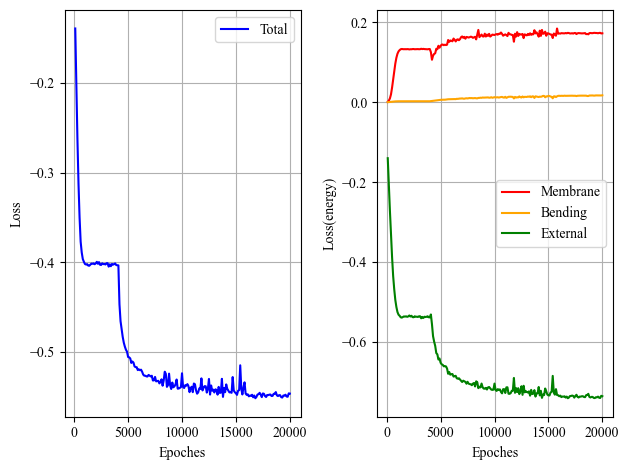

Run time: 2749.2918 s


In [18]:
# Set up parameters for outer training
nEpochesAdam = 20000 # 20000
intervalAdam = 100
learningRate = 2e-3

# Set up details for optimizers
optimizerAdam = Adam(
    list(NetU.parameters()) + list(NetV.parameters()) + list(NetW.parameters()) ,
    lr=learningRate,
    weight_decay=0)

scheduler = ReduceLROnPlateau(
    optimizerAdam,
    mode='min',
    factor=0.5,
    patience=2000, # 2000
    threshold=1e-4,
    min_lr=1e-5
)

# Set up recorders for monitoring
lossHistory_adam = []
energy = {'membrane': None,'bending': None, "external": None}

start_time = time.time()

if runMode == True:
    # First stage: Adam
    #print('First stage: Adam')
    for epoch in range(nEpochesAdam):
        # Evaluate the loss then implement backpropagation
        Phi_m, Phi_b, V = freeEnergy(inputData, NetU, NetV, NetW, funcUV, funcW)
        loss = Phi_m + Phi_b + V
        loss.backward()
        optimizerAdam.step()
        optimizerAdam.zero_grad()
        scheduler.step(loss.item())

        # Monitor
        if (epoch + 1) % intervalAdam == 0:
            # Re-sampling
            inputData = trainingData(nSample)

            # Record the loss history
            loss_Phi_m = Phi_m.detach().cpu().item()
            loss_Phi_b = Phi_b.detach().cpu().item()
            loss_V = V.detach().cpu().item()
            totalLoss = loss_Phi_m + loss_Phi_b + loss_V
            lossHistory_adam.append([totalLoss, loss_Phi_m, loss_Phi_b, loss_V])
            print(f'Epoch:{epoch+1}, '
                  f'Total:{totalLoss:.4e}, '
                  f'Membrane:{loss_Phi_m:.4e}, '
                  f'Bending:{loss_Phi_b:.4e}, '
                  f'External:{loss_V:.4e} ')

    # Show the loss history
    timeAdam = [(i + 1)*intervalAdam for i in range(len(lossHistory_adam))]
    lossHistory_adam = np.array(lossHistory_adam)

    loss_data = np.column_stack((timeAdam, lossHistory_adam))
    np.savetxt(f'{material}-plate-loss.dat', loss_data, fmt='%.8f')

    fig = plt.figure()

    # Total loss
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(timeAdam, lossHistory_adam[:, 0], label='Total', color='blue')
    ax1.set_xlabel('Epoches')
    ax1.set_ylabel('Loss')
    ax1.grid(True)
    ax1.legend(loc='best')

    # Energy in time
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(timeAdam, lossHistory_adam[:, 1], label='Membrane', color='red')
    ax2.plot(timeAdam, lossHistory_adam[:, 2], label='Bending', color='orange')
    ax2.plot(timeAdam, lossHistory_adam[:, 3], label='External', color='green')
    ax2.set_xlabel('Epoches')
    ax2.set_ylabel('Loss(energy)')
    ax2.legend(loc='best')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


    # Save the model
    torch.save(NetU.state_dict(), f'{material}-plate-NetU.pth')
    torch.save(NetV.state_dict(), f'{material}-plate-NetV.pth')
    torch.save(NetW.state_dict(), f'{material}-plate-NetW.pth')

end_time = time.time()

run_time = end_time - start_time
print(f'Run time: {run_time:.4f} s')

### Prediction

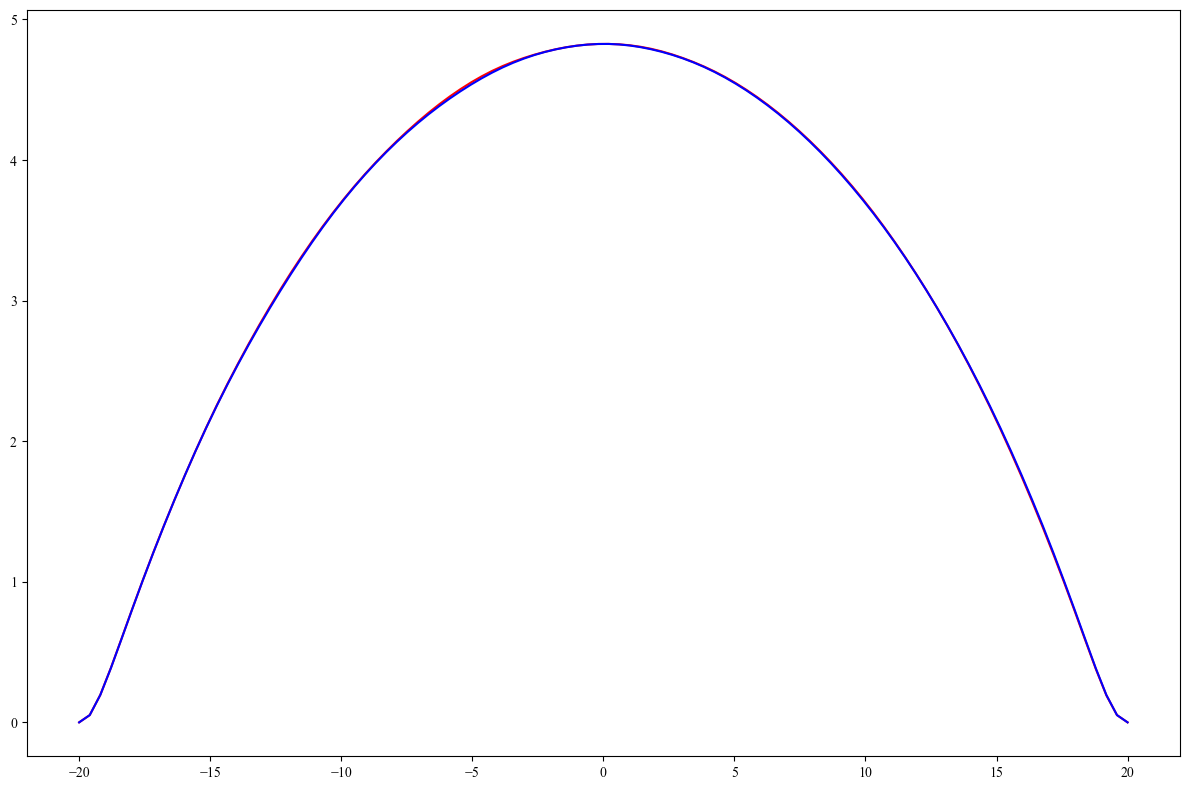

The maximum deflection is 4.8258843421936035nm


In [19]:
if runMode == False:
    # Load the model's parameters
    NetU.load_state_dict(torch.load(f'{material}-plate-NetU.pth', weights_only=True))
    NetV.load_state_dict(torch.load(f'{material}-plate-NetV.pth', weights_only=True))
    NetW.load_state_dict(torch.load(f'{material}-plate-NetW.pth', weights_only=True))

    # Set the model to evaluation mode (important for inference)
    NetU.eval()
    NetV.eval()
    NetW.eval()

coordinates_x = torch.column_stack((torch.linspace(-A, A, steps=100), torch.zeros(100)))
coordinates_y = torch.column_stack((torch.zeros(100),torch.linspace(-A, A, steps=100)))
W_x = NetW(coordinates_x)*(funcW(coordinates_x).view(-1, 1))
W_y = NetW(coordinates_y)*(funcW(coordinates_y).view(-1, 1))
w_x = W_x.detach().cpu().numpy().reshape(-1)*he*1e9
w_y = W_y.detach().cpu().numpy().reshape(-1)*he*1e9
r = torch.linspace(-A, A, steps=100).detach().cpu().numpy().reshape(-1)*he*1e9
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.plot(r, w_x, color='red')
ax.plot(r, w_y, color='blue')
plt.tight_layout()
plt.show()
predictData_line = np.stack((r, w_x), axis=1)
np.savetxt(fname=f'{material}-plate-prediction-line.dat',X=predictData_line,fmt='%.8f')


meshSize = A/50
with pgm.geo.Geometry() as geom:
    disk = geom.add_circle(x0=[0.0, 0.0, 0.0], radius=A, mesh_size=meshSize)
    diskMesh = geom.generate_mesh()
    coordinates = torch.tensor(diskMesh.points[:, 0:2],
                               dtype=torch.float32,
                               requires_grad=True)

# Prediction
U = NetU(coordinates)*(funcUV(coordinates).view(-1, 1))
V = NetV(coordinates)*(funcUV(coordinates).view(-1, 1))
W = NetW(coordinates)*(funcW(coordinates).view(-1, 1))

# Transport all the tensors onto CPU for post-process(nanometer)
x = coordinates[:, 0].detach().cpu().numpy().reshape(-1)*he*1e9
y = coordinates[:, 1].detach().cpu().numpy().reshape(-1)*he*1e9
r = np.linspace(-A, A, 200)*he*1e9
u = U.detach().cpu().numpy().reshape(-1)*he*1e9
v = V.detach().cpu().numpy().reshape(-1)*he*1e9
w = W.detach().cpu().numpy().reshape(-1)*he*1e9

# Check the maximum deflection
print(f'The maximum deflection is {max(w)}nm')

# Save the data from prediction
predictData_all = np.stack((x, y, u, v, w), axis=1)
np.savetxt(fname=f'{material}-plate-prediction.dat',X=predictData_all,fmt='%.8f')



### Visualization

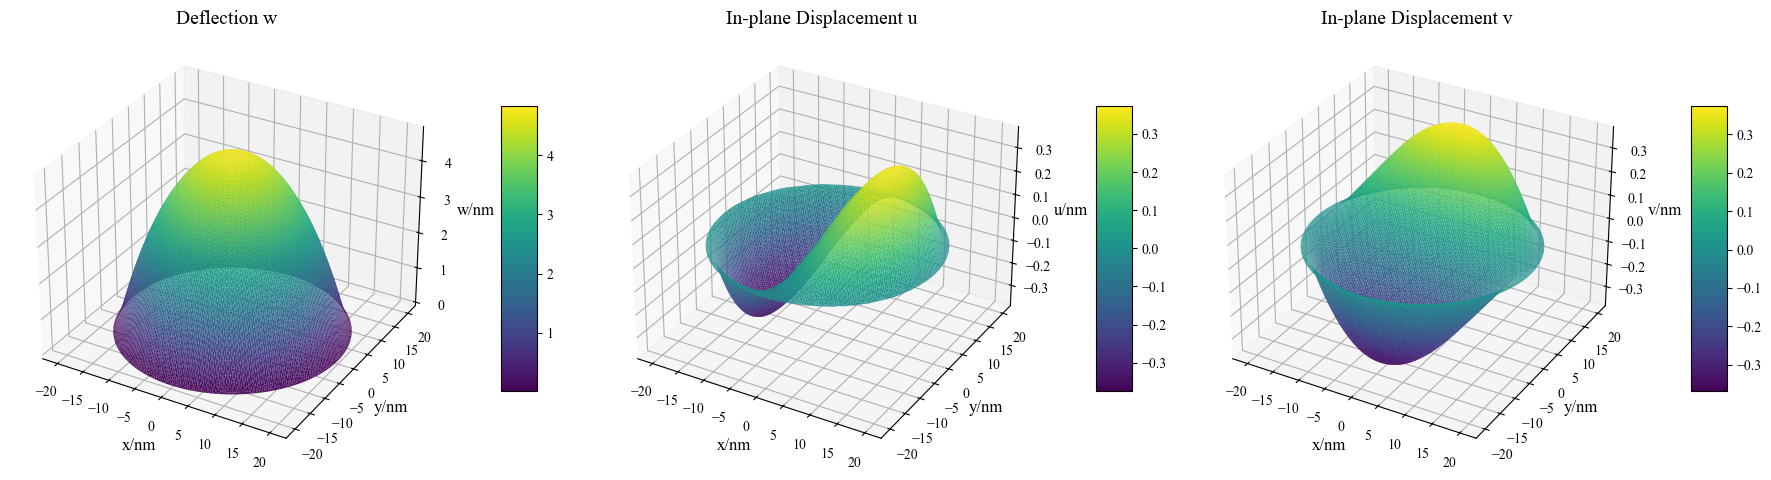

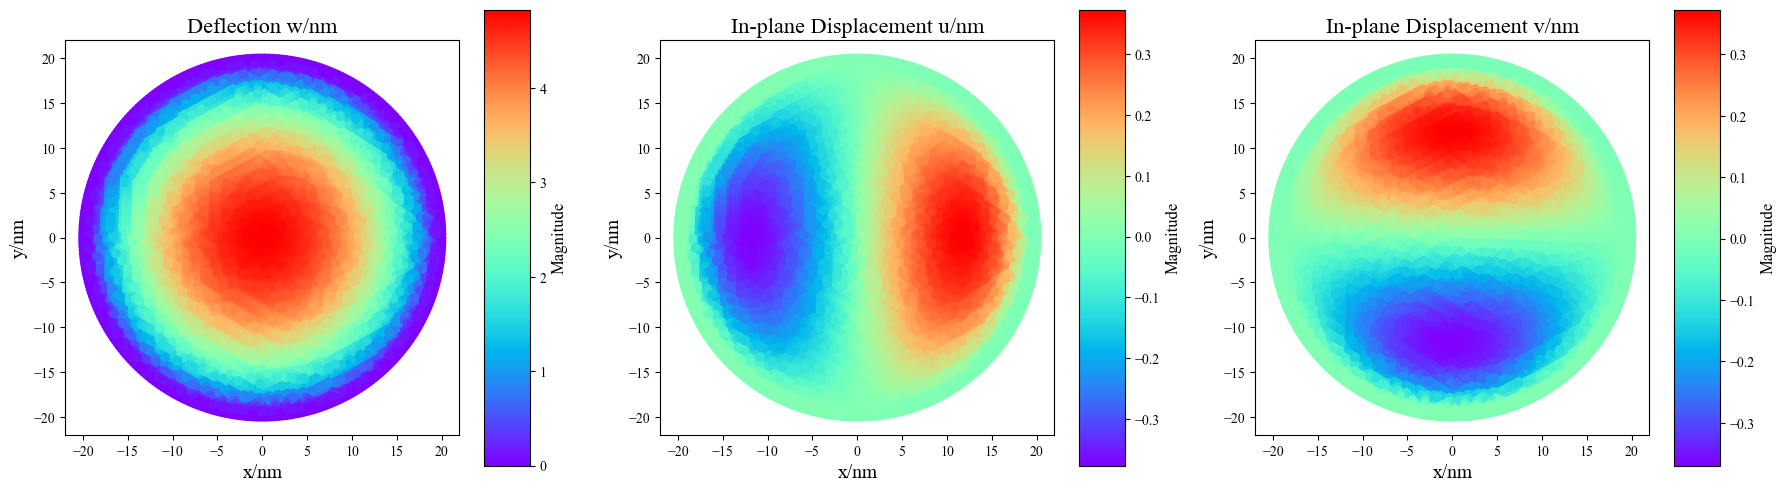

In [20]:

matplotlib.rcParams['font.family'] = 'Times New Roman'

# Surface
fig1 = plt.figure(figsize=(18, 6))

subplotw = fig1.add_subplot(131, projection='3d')
surfw = subplotw.plot_trisurf(x, y, w, cmap='viridis', linewidth=0.2, antialiased=True)
subplotw.set_title(r'Deflection w', fontsize=14)
subplotw.set_xlabel(r'x/nm', fontsize=12)
subplotw.set_ylabel(r'y/nm', fontsize=12)
subplotw.set_zlabel(r'w/nm', fontsize=12)
fig1.colorbar(surfw, ax=subplotw, shrink=0.5, aspect=8, fraction=0.15, pad=0.1)

subplotu = fig1.add_subplot(132, projection='3d')
surfu = subplotu.plot_trisurf(x, y, u, cmap='viridis', linewidth=0.2, antialiased=True)
subplotu.set_title(r'In-plane Displacement u', fontsize=14)
subplotu.set_xlabel(r'x/nm', fontsize=12)
subplotu.set_ylabel(r'y/nm', fontsize=12)
subplotu.set_zlabel(r'u/nm', fontsize=12)
fig1.colorbar(surfu, ax=subplotu, shrink=0.5, aspect=8, fraction=0.15, pad=0.1)

subplotv = fig1.add_subplot(133, projection='3d')
surfv = subplotv.plot_trisurf(x, y, v, cmap='viridis', linewidth=0.2, antialiased=True)
subplotv.set_title(r'In-plane Displacement v', fontsize=14)
subplotv.set_xlabel(r'x/nm', fontsize=12)
subplotv.set_ylabel(r'y/nm', fontsize=12)
subplotv.set_zlabel(r'v/nm', fontsize=12)
fig1.colorbar(surfv, ax=subplotv, shrink=0.5, aspect=8, fraction=0.15, pad=0.1)

plt.tight_layout()
plt.show()

# Scatter
fig2 = plt.figure(figsize=(18, 6))

subplotww = fig2.add_subplot(131)
scw = subplotww.scatter(x, y, c=w, cmap='rainbow')
subplotww.set_title(r'Deflection w/nm', fontsize=16)
subplotww.set_xlabel(r'x/nm', fontsize=14)
subplotww.set_ylabel(r'y/nm', fontsize=14)
subplotww.set_aspect('equal')
cbw = plt.colorbar(scw, ax=subplotww, shrink=0.8, aspect=10)
cbw.set_label('Magnitude', fontsize=12)

subplotuu = fig2.add_subplot(132)
scu = subplotuu.scatter(x, y, c=u, cmap='rainbow')
subplotuu.set_title(r'In-plane Displacement u/nm', fontsize=16)
subplotuu.set_xlabel(r'x/nm', fontsize=14)
subplotuu.set_ylabel(r'y/nm', fontsize=14)
subplotuu.set_aspect('equal')
cbu = plt.colorbar(scu, ax=subplotuu, shrink=0.8, aspect=10)
cbu.set_label('Magnitude', fontsize=12)

subplotvv = fig2.add_subplot(133)
scv = subplotvv.scatter(x, y, c=v, cmap='rainbow')
subplotvv.set_title(r'In-plane Displacement v/nm', fontsize=16)
subplotvv.set_xlabel(r'x/nm', fontsize=14)
subplotvv.set_ylabel(r'y/nm', fontsize=14)
subplotvv.set_aspect('equal')
cbv = plt.colorbar(scv, ax=subplotvv, shrink=0.8, aspect=10)
cbv.set_label('Magnitude', fontsize=12)

plt.tight_layout()
plt.show()
